In [2]:
import ctypes
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import math
from PIL import Image


In [3]:
from torchvision import transforms
from sklearn.preprocessing import LabelEncoder, LabelBinarizer
import numpy as np

transform = transforms.Compose([
    transforms.Resize((64, 64)),
    transforms.ToTensor()
])

def preprocess_for_rust(images, labels):
    X = np.stack([transform(img).numpy().flatten() for img in images])
    X = X.astype(np.float64)

    le = LabelEncoder()
    y_int = le.fit_transform(labels)

    lb = LabelBinarizer()
    y_onehot = lb.fit_transform(y_int)
    if y_onehot.shape[1] == 1:  # pour les cas binaire
        y_onehot = np.hstack([1 - y_onehot, y_onehot])

    y_onehot = y_onehot.astype(np.float64)

    return X, y_onehot, le


In [4]:
# Charger la bibliothèque Rust
lib = ctypes.CDLL("target/release/mymodel.dll")

# Spécifier les types
lib.create_rbfn_multiclass_model.argtypes = [ctypes.c_double, ctypes.c_double, ctypes.c_size_t, ctypes.c_size_t]
lib.create_rbfn_multiclass_model.restype = ctypes.c_void_p

lib.train_rbfn_model_auto.argtypes = [
    ctypes.c_void_p,
    ctypes.POINTER(ctypes.c_double),
    ctypes.POINTER(ctypes.c_double),
    ctypes.c_size_t, ctypes.c_size_t, ctypes.c_size_t
]

lib.predict_rbfn_model.argtypes = [ctypes.c_void_p, ctypes.POINTER(ctypes.c_double), ctypes.c_size_t]
lib.predict_rbfn_model.restype = ctypes.c_double

In [5]:
def load_images_from_folder(folder_path):
    images, labels = [], []

    for label in os.listdir(folder_path):
        label_path = os.path.join(folder_path, label)
        if not os.path.isdir(label_path):
            continue

        for filename in os.listdir(label_path):
            if filename.lower().endswith((".png", ".jpg", ".jpeg", ".bmp", ".gif")):
                image_path = os.path.join(label_path, filename)
                try:
                    image = Image.open(image_path).convert("RGB")
                    images.append(image)
                    labels.append(label)
                except Exception as e:
                    print(f"Erreur lors de l'ouverture de {image_path}: {e}")

    return images, labels

In [6]:
# Chargement séparé
images_train, labels_train = load_images_from_folder("dataset/train")
images_test, labels_test = load_images_from_folder("dataset/test")

# Prétraitement
X_train, Y_train, label_encoder = preprocess_for_rust(images_train, labels_train)
X_test, Y_test, _ = preprocess_for_rust(images_test, labels_test)

n_train, n_features = X_train.shape
n_outputs = Y_train.shape[1]

Erreur lors de l'ouverture de dataset/test\A\A_003.jpg: cannot identify image file 'C:\\PA\\dataset\\test\\A\\A_003.jpg'
Erreur lors de l'ouverture de dataset/test\B\B_002.jpg: cannot identify image file 'C:\\PA\\dataset\\test\\B\\B_002.jpg'


In [7]:
# Avant la normalisation 
print("X_train dtype :", X_train.dtype)
print("X_train shape :", X_train.shape)
print("X_train min :", np.min(X_train))
print("X_train max :", np.max(X_train))
print("X_train[0][:10] :", X_train[0][:10])


X_train dtype : float64
X_train shape : (3695, 12288)
X_train min : 0.0
X_train max : 1.0
X_train[0][:10] : [0.58039218 0.58039218 0.58039218 0.58039218 0.58039218 0.58039218
 0.58039218 0.58039218 0.58039218 0.58039218]


In [8]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)


In [9]:
print("X_train dtype :", X_train.dtype)
print("X_train shape :", X_train.shape)
print("X_train min :", np.min(X_train))
print("X_train max :", np.max(X_train))
print("X_train[0][:10] :", X_train[0][:10])


X_train dtype : float64
X_train shape : (3695, 12288)
X_train min : -2.4053817875390564
X_train max : 3.504669249772791
X_train[0][:10] : [0.192558   0.18739496 0.18602258 0.19032807 0.1880492  0.18486741
 0.18944932 0.19144236 0.18641289 0.18562507]


In [10]:
# --- Créer le modèle RBFN ---
model_ptr = lib.create_rbfn_multiclass_model(1.0, 0.01, 100, n_outputs)

# --- Entraîner le modèle ---
x_train_ptr = X_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
y_train_ptr = Y_train.ctypes.data_as(ctypes.POINTER(ctypes.c_double))

lib.train_rbfn_model_auto(model_ptr, x_train_ptr, y_train_ptr, n_train, n_features, n_outputs)

1

In [11]:
# --- Fonction de prédiction ---
def predict_image(model_ptr, image):
    x = transform(image).numpy().flatten().astype(np.float64)
    x_ptr = x.ctypes.data_as(ctypes.POINTER(ctypes.c_double))
    pred = int(lib.predict_rbfn_model(model_ptr, x_ptr, x.shape[0]))
    return label_encoder.inverse_transform([pred])[0]

In [12]:
# --- Évaluation sur le test set ---
y_pred = [predict_image(model_ptr, img) for img in images_test]
# --- Résultat ---
print("✅ Accuracy sur données de test :", accuracy_score(labels_test, y_pred))

✅ Accuracy sur données de test : 0.3263736263736264


In [10]:

def afficher_toutes_les_predictions(images, labels, model_ptr):
    n = len(images)  # nombre total d’images à afficher
    cols = 10        # nombre d’images par ligne
    rows = math.ceil(n / cols)

    plt.figure(figsize=(cols * 2, rows * 2))

    for i in range(n):
        plt.subplot(rows, cols, i + 1)
        plt.imshow(images[i])
        plt.axis('off')

        pred = predict_image(model_ptr, images[i])
        true = labels[i]

        color = "green" if pred == true else "red"
        plt.title(f"P: {pred}\nR: {true}", fontsize=8, color=color)

    plt.tight_layout()
    plt.show()


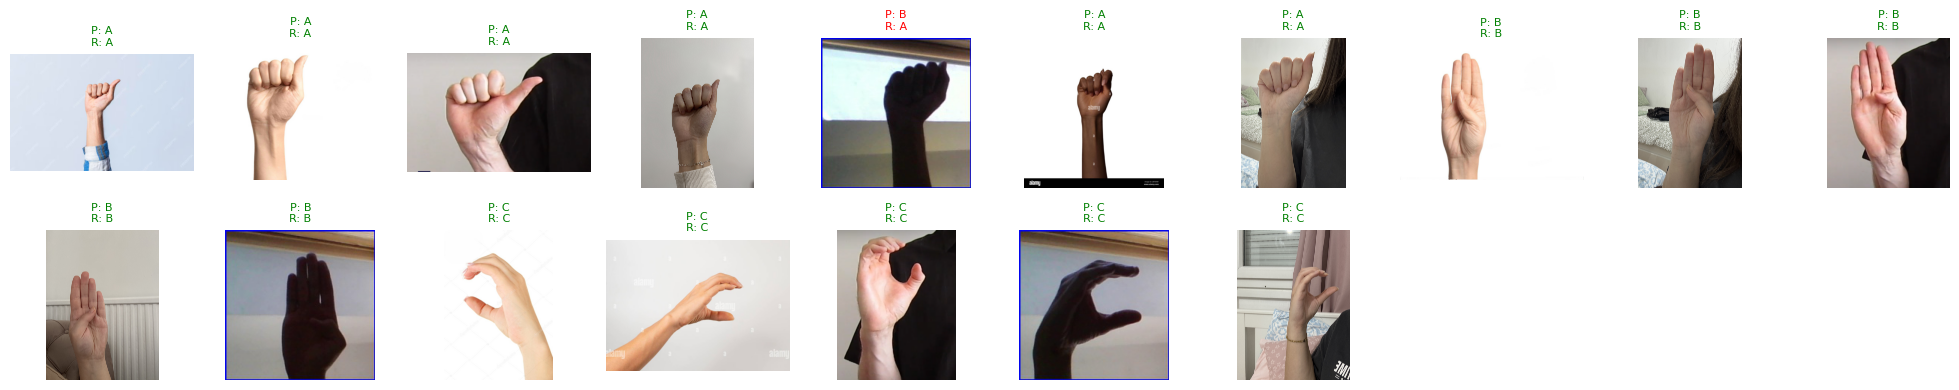

In [11]:
afficher_toutes_les_predictions(images_test, labels_test, model_ptr)

In [11]:
y_preds = [lib.predict_rbfn_model(model_ptr, x.ctypes.data_as(ctypes.POINTER(ctypes.c_double)), n_features)
           for x in X_test]

print("Prédictions:", y_preds)
print("Labels vrais:", Y_test.tolist())


Prédictions: [0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 1.0, 1.0, 1.0, 1.0, 1.0, 2.0, 2.0, 2.0, 2.0, 2.0]
Labels vrais: [[1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [1.0, 0.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 1.0, 0.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0], [0.0, 0.0, 1.0]]
